In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import math
import matplotlib.pyplot as plt
import seaborn as sns

Источник дата сета [ссылка](https://www.kaggle.com/datasets/chetanism/foursquare-nyc-and-tokyo-checkin-dataset?resource=download)

#### План работы:
- [Шаг 1. Исследовательский анализ данных](#step1)
    - [Загрузка, преобразование utcTimestamp](#step2)  
    - [Анализ распределения данных времени и локации событий (дом/не дом)](#step3)
    - [Исключение пользователей с аномальным кол-вом событий вне дома в 1 день](#step4)  
- [Шаг 2. Кластеризация координат локаций с помощью алгоритма KMeans](#step5)
    - [Кластеризация координат локаций вне дома](#step6)
    - [Функция расчета расстояний в метрах между координатами](#step7)
    - [Визуализация полученных кластеров (на примере нескольких)](#step8)
    - [Кластеризация домашних адресов](#step9)
    - [Определение для каждого пользователя одного адреса в качестве домашнего](#step10)
- [Шаг 3. Определение типа локаций, которые пользователи чаще посещают близко / далеко от дома](#step11)
    - [Расстояние от центра кластера дом до центров кластеров локаций для каждого пользователя](#step12)
    - [Топ 15 самых ближних часто посещаемых к дому локаций](#step13)
    - [Топ 15 самых удаленных часто посещаемых от дома локаций](#step14)
- [Шаг 4. Выводы](#step15)

#### Описание данных
df:  
- `userId` уникальный идентивикатор пользователя. 
- `venueCategory` категория локации, которую пользователь посещал (аэропорт, аптека, дом и т.д.)
- `utcTimestamp` дата посещения пользователем локации
- `latitude` координата широты локации
- `longitude` координата долготы локации

### Исследовательский анализ данных<a id=step1>

### Загрузка, преобразование utcTimestamp<a id=step2>

In [2]:
df = pd.read_csv('dataset_TSMC2014_NYC.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227428 entries, 0 to 227427
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   userId           227428 non-null  int64  
 1   venueId          227428 non-null  object 
 2   venueCategoryId  227428 non-null  object 
 3   venueCategory    227428 non-null  object 
 4   latitude         227428 non-null  float64
 5   longitude        227428 non-null  float64
 6   timezoneOffset   227428 non-null  int64  
 7   utcTimestamp     227428 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 13.9+ MB


In [4]:
df['date'] = pd.DatetimeIndex(df['utcTimestamp'])
df['date'] = df['date'].dt.date
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [5]:
df.head(2)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,date
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.71981,-74.002581,-240,Tue Apr 03 18:00:09 +0000 2012,2012-04-03
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.60680,-74.044170,-240,Tue Apr 03 18:00:25 +0000 2012,2012-04-03


### Анализ распределения данных времени и локации событий (дом/не дом) <a id=step3>

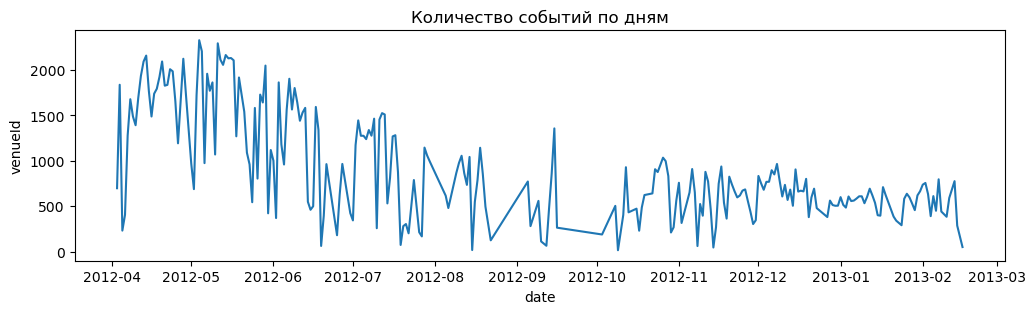

In [6]:
#событий в день на 1 пользователя
pv = df.pivot_table(index=['date'] ,values='venueId', aggfunc='count').reset_index()
plt.figure(figsize=(12, 3))
plt.title('Количество событий по дням')
ax = sns.lineplot(x="date", y="venueId", data=pv)

Для расчетов оставим только пользователей, чьи домашние адреса нам известны.

In [7]:
users_home = df.loc[df['venueCategory'] == 'Home (private)']['userId'].values
df = df.query('userId in @users_home')
df.groupby('userId').agg({'venueCategoryId':'nunique'}).describe().T

,count,mean,std,min,25%,50%,75%,max
venueCategoryId,587.0,49.340716,19.313908,7.0,36.0,47.0,60.0,180.0


Каждый из пользователей совершает некоторое количество событий в нескольких категориях локаций. Половина пользователей посетила до 47 локаций и не менее 7. 

#### Cобытия не дома

In [8]:
df_venue_not_home = df.loc[df['venueCategory'] != 'Home (private)']

In [9]:
#удалим дубликаты где пользователь в 1 день отмечался более 1 раза в одном и том же месте
print('Доля событий, где пользователь отмечали в один день более 1 раза {:.2%}'
      .format(df_venue_not_home.duplicated(subset=['userId', 'date', 'venueCategoryId']).sum()
              /len(df_venue_not_home)))
df_venue_not_home.drop_duplicates(subset=['userId', 'date', 'venueCategoryId'], inplace=True)

Доля событий, где пользователь отмечали в один день более 1 раза 12.47%


/var/folders/z_/prw26dp909b0qyhxlmh35myh0000gn/T/ipykernel_9813/818620945.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_venue_not_home.drop_duplicates(subset=['userId', 'date', 'venueCategoryId'], inplace=True)


### Исключение пользователей с аномальным кол-вом событий вне дома в 1 день<a id=step4>

In [10]:
#событий в день на 1 пользователя
abnormal = df_venue_not_home.pivot_table(index=['userId','date'] ,values='venueId', aggfunc='count').reset_index()

[(0.0, 35.0)]

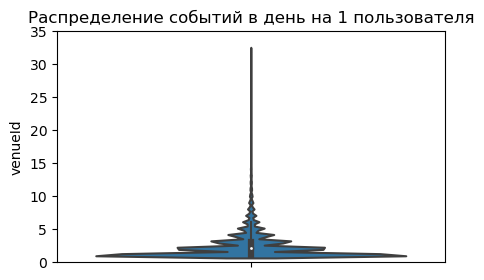

In [11]:
plt.figure(figsize=(5,3))
plt.title('Распределение событий в день на 1 пользователя')
ax = sns.violinplot(y='venueId', data=abnormal)
ax.set(ylim=(0, 35))

In [12]:
Q1 = abnormal['venueId'].quantile(0.25)
Q3 = abnormal['venueId'].quantile(0.75)
IQR = Q3 - Q1
print('max', Q3+6*IQR)
print('Аномальных userId', abnormal[abnormal['venueId']>Q3+6*IQR]['userId'].nunique())
print('Аномальных userId {:.2%}'.format(abnormal[abnormal['venueId']>Q3+6*IQR]['userId'].nunique()
                                        /abnormal['userId'].nunique()))

max 15.0
Аномальных userId 23
Аномальных userId 3.92%


In [13]:
abnormal_users = abnormal[abnormal['venueId']>15]['userId'].unique()
df_venue_not_home = df_venue_not_home.query('userId not in @abnormal_users')

#### Cобытия дома

In [14]:
#дом
df_venue_home = df.copy()
df_venue_home = df_venue_home.loc[df_venue_home['venueCategory'] == 'Home (private)']
df_venue_home.duplicated().sum()
df_venue_home.drop_duplicates(inplace=True)
df_venue_home.rename(columns={'latitude':'lat_home', 'longitude':'lon_home'}, inplace=True)
#df_venue_home['lat_lot'] = df_venue_home[['lat_home', 'lon_home']].astype(str).agg(' '.join, axis=1)
df_venue_home.head(2)

,userId,venueId,venueCategoryId,venueCategory,lat_home,lon_home,timezoneOffset,utcTimestamp,date
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,Tue Apr 03 18:02:24 +0000 2012,2012-04-03
8,428,4ce1863bc4f6a35d8bd2db6c,4bf58dd8d48988d103941735,Home (private),40.619151,-74.035888,-240,Tue Apr 03 18:06:18 +0000 2012,2012-04-03


#### Оставим пользователей, которые есть в обоих датафреймах (с адресом и с неаномальным кол-вом событий)

In [15]:
userId = df_venue_home.loc[:,['userId']].merge(df_venue_not_home.loc[:, ['userId']], how='inner').drop_duplicates()
userId = userId['userId'].to_list()
df_venue_home = df_venue_home.query('userId in @userId')
df_venue_not_home = df_venue_not_home.query('userId in @userId')

In [16]:
print('Итого пользователей для анализа:', df_venue_home['userId'].nunique())
print('Итого категорий локаций для анализа:', df_venue_not_home['venueCategory'].nunique())

Итого пользователей для анализа: 564
Итого категорий событий для анализа: 248


### Кластеризация координат локаций с помощью алгоритма KMeans<a id=step5>  

#### Кластеризация координат локаций вне дома<a id=step6>

In [17]:
df_cl = df_venue_not_home.loc[:, ['userId', 'venueCategoryId', 'venueCategory', 'latitude', 'longitude', 'date']]
df_cl = df_cl.set_index(['userId', 'venueCategoryId', 'venueCategory', 'date'])

In [18]:
model = KMeans(n_clusters=1000, random_state=12345)
model.fit(df_cl)

/Users/julia/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=1000, random_state=12345)

In [19]:
centroids = pd.DataFrame(model.cluster_centers_, columns=['latitude', 'longitude'])
df_cl['label'] = model.labels_.astype(str)
centroids = centroids.reset_index()
centroids.columns = ['label', 'latitude', 'longitude']
df_cl['label'] = df_cl['label'].astype('int')
df_cl_all = df_cl.merge(centroids, how='left', on='label')
df_cl_all.columns = ['latitude', 'longitude', 'claster', 'latitude_centroid', 'longitude_centroid']
#добавим user_id 
df_cl = df_cl.reset_index().drop(columns='label')
df_cl_all = df_cl_all.merge(df_cl, how='left', on=['latitude', 'longitude'])

In [20]:
#посмотрим на распределение кол-ва координат и пользователей в каждом кластере
df_cl_all.groupby(['claster']).agg({'userId':'nunique',
                                    'longitude':'count', 'latitude_centroid':'nunique'}).describe()

,userId,longitude,latitude_centroid
count,1000.000000,1000.000000,1000.0
mean,23.988000,2247.835000,1.0
std,30.579159,7714.539776,0.0
min,1.000000,2.000000,1.0
25%,7.000000,154.000000,1.0
50%,13.000000,612.500000,1.0
75%,25.000000,2009.250000,1.0
max,229.000000,163540.000000,1.0


#### Функция расчета расстояний в метрах между координатами<a id=step7>

In [21]:
#посчитаем расстояния в метрах от центра кластера до точек координат, которые в него входят
def d(row):
    latitude_centroid = row[3]
    latitude = row[0]
    longitude_centroid = row[4]
    longitude = row[1]
    for i in range(len(row)):
        R = 6371000
        lat1 = latitude_centroid * math.pi / 180
        lat2 = latitude * math.pi / 180
        delta_lat = ((latitude - latitude_centroid) * math.pi / 180)
        delta_lon = ((longitude - longitude_centroid) * math.pi / 180)
        a=math.sin(delta_lat/2)*math.sin(delta_lat/2)+ math.cos(lat1)*math.cos(lat2)*math.sin(delta_lon/2)*math.sin(delta_lon/2)
        c = 2*math.atan2(math.sqrt(a),math.sqrt(1-a))
        d=R*c
    return d
df_cl_all['distance_venue_centroid'] = df_cl_all.apply(d, axis=1)

In [22]:
np.percentile(df_cl_all['distance_venue_centroid'], [25, 50, 75, 95])

array([ 33.23220742,  67.75868664, 122.57741389, 257.36639732])

In [23]:
df_cl_all.head(2)

,latitude,longitude,claster,latitude_centroid,longitude_centroid,userId,venueCategoryId,venueCategory,date,distance_venue_centroid
0,40.745164,-73.982519,779,40.746023,-73.981627,395,4bf58dd8d48988d104941735,Medical Center,2012-04-03,121.543900
1,40.740104,-73.989658,658,40.741668,-73.989308,87,4bf58dd8d48988d1cb941735,Food Truck,2012-04-03,176.433269


#### Визуализация полученных кластеров (на примере нескольких)<a id=step8>
для примера возьмем 2 ближайших кластера 

In [24]:
#поиск 2ух ближайших кластеров
near_clus = df_cl_all.sort_values(by=['latitude_centroid', 'longitude_centroid']).groupby(['claster']).head(1)
near_clus.tail(2)

,latitude,longitude,claster,latitude_centroid,longitude_centroid,userId,venueCategoryId,venueCategory,date,distance_venue_centroid
397185,40.972108,-73.978759,687,40.974382,-73.978416,678,4bf58dd8d48988d163941735,Park,2012-04-29,254.567188
534817,40.977457,-74.025827,247,40.978845,-74.024877,773,4f2a25ac4b909258e854f55f,Neighborhood,2012-05-10,173.681754


In [25]:
sc_l = df_cl_all[df_cl_all['claster'].isin([687, 247])][['latitude', 'longitude','claster']]
sc_l['hue'] = 'lat_lon'
sc_l.columns = ['latitude', 'longitude', 'claster', 'hue']
sc_c = df_cl_all[df_cl_all['claster'].isin([687, 247])][['latitude_centroid', 'longitude_centroid','claster']]
sc_c['hue'] = 'centroid'
sc_c.columns = ['latitude', 'longitude', 'claster', 'hue']
sc = pd.concat([sc_c, sc_l], ignore_index=True)
sc_c.head(2)

,latitude,longitude,claster,hue
397185,40.974382,-73.978416,687,centroid
534817,40.978845,-74.024877,247,centroid


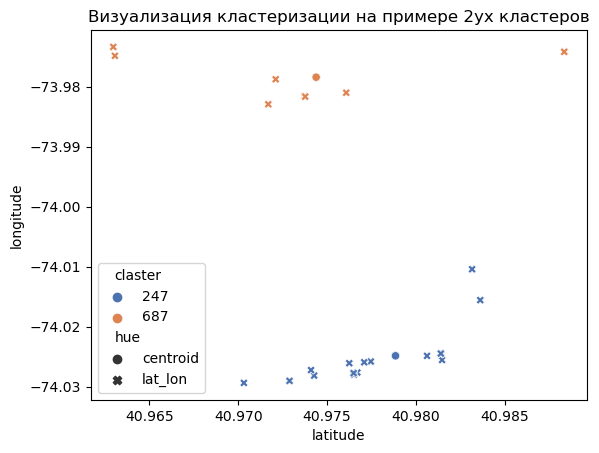

In [26]:
plt.title('Визуализация кластеризации на примере 2ух кластеров')
sns.scatterplot(data = sc, x='latitude', y='longitude', hue='claster', style='hue', palette="deep");

#### Кластеризация домашних адресов<a id=step9>

In [27]:
df_cl_h = df_venue_home.loc[:, ['userId', 'venueCategoryId', 'venueCategory', 'lat_home', 'lon_home', 'date']]
df_cl_h = df_cl_h.set_index(['userId', 'venueCategoryId', 'venueCategory', 'date'])

In [28]:
model = KMeans(n_clusters=300, random_state=12345)
model.fit(df_cl_h)

/Users/julia/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=300, random_state=12345)

In [29]:
centroids = pd.DataFrame(model.cluster_centers_, columns=['lat_home', 'lon_home'])
df_cl_h['label'] = model.labels_.astype(str)
centroids = centroids.reset_index()
centroids.columns = ['label', 'lat_home', 'lon_home']
df_cl_h['label'] = df_cl_h['label'].astype('int')
df_cl_all_h = df_cl_h.merge(centroids, how='left', on='label')
df_cl_all_h.columns = ['lat_home', 'lon_home', 'claster', 'lat_home_centroid', 'lon_home_centroid']
#добавим user_id, date
df_cl_h = df_cl_h.reset_index().drop(columns='label')
df_cl_all_h = df_cl_all_h.merge(df_cl_h, how='left', on=['lat_home', 'lon_home'])

In [30]:
#посмотрим на распределение кол-ва координат и пользователей в каждом кластере
df_cl_all_h.groupby(['claster']).agg({'userId':'nunique',
                                    'lon_home':'count', 'lat_home_centroid':'nunique'}).describe()

,userId,lon_home,lat_home_centroid
count,300.000000,300.000000,300.0
mean,3.506667,5071.646667,1.0
std,2.836095,16295.410036,0.0
min,1.000000,3.000000,1.0
25%,2.000000,287.000000,1.0
50%,3.000000,901.000000,1.0
75%,4.000000,2971.000000,1.0
max,26.000000,204320.000000,1.0


#### Расстояние в метрах между центроидом и домашними координатами

In [31]:
df_cl_all_h['distance_home_centroid'] = df_cl_all_h.apply(d, axis=1)

In [32]:
np.percentile(df_cl_all_h['distance_home_centroid'], [25, 50, 75, 95])

array([ 0.        ,  4.04137756, 12.72147395, 93.02706733])

In [33]:
df_cl_all_h = df_cl_all_h.loc[:, ['userId', 'lat_home_centroid'
                                  , 'lon_home_centroid', 'claster', 'date']].drop_duplicates()
df_cl_all_h.groupby(['userId']).agg({'claster':'nunique'}).describe().T

,count,mean,std,min,25%,50%,75%,max
claster,564.0,1.865248,1.276762,1.0,1.0,1.0,2.0,10.0


У 25% пользователей 2 и более кластера на домашний адрес, возможно, что они отмечают статус дома не только находясь у себя дома. Проанализируем распределение количества событий по разным адресам и определим для 1 пользователя 1 домашний адрес по наибольшему числу событий в нем

#### Определение для каждого пользователя одного адреса в качестве домашнего<a id=step10>

[(0.0, 75.0)]

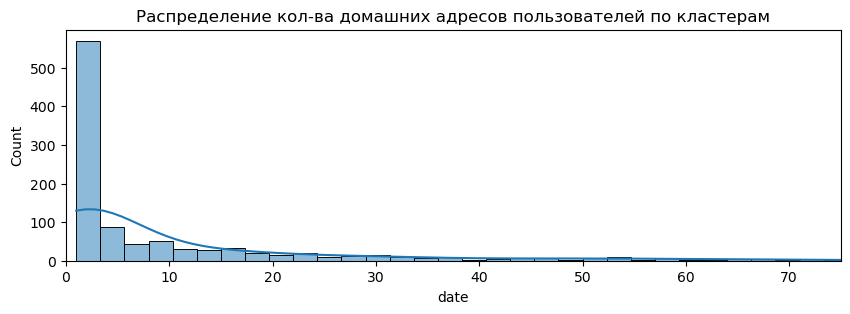

In [34]:
count_venue_h = df_cl_all_h.groupby(['userId', 'claster']).agg({'date':'count'}).reset_index()
plt.figure(figsize=(10,3))
plt.title('Распределение кол-ва домашних адресов пользователей по кластерам')
ax = sns.histplot(count_venue_h['date'], kde=True) 
ax.set(xlim=(0, 75))

In [35]:
#для каждого пользователя оставим домашний адрес с наибольшим кол-вом событий
df_cl_all_h = (df_cl_all_h.groupby(['userId','claster','lat_home_centroid', 'lon_home_centroid'])
               .agg({'date':'count'}).reset_index()
               .sort_values(by=['userId','date'], ascending=False))
df_cl_all_h = df_cl_all_h.groupby(['userId']).head(1)

In [36]:
#проверка, что у 1 пользователя только 1 домашний адрес
df_cl_all_h.groupby(['userId']).agg({'claster':['nunique']}).max()

claster  nunique    1
dtype: int64

#### Добавим центры кластеров домашних адресов пользователей в таблицу c результатами кластеризации событий

In [37]:
df_clust_home_venue = df_cl_all.merge(df_cl_all_h.loc[:, ['userId', 'lat_home_centroid', 'lon_home_centroid']]
                                , how='left', on = ['userId'])

In [38]:
df_clust_home_venue['latitude'] = df_clust_home_venue['lat_home_centroid']
df_clust_home_venue['longitude'] = df_clust_home_venue['lon_home_centroid']
df_clust_home_venue.rename(columns={'latitude':'lat_home_centroid', 'longitude':'lon_home_centroid'}, inplace=True)
df_clust_home_venue = df_clust_home_venue.iloc[:, :10]

In [39]:
df_clust_home_venue.head(2)

,lat_home_centroid,lon_home_centroid,claster,latitude_centroid,longitude_centroid,userId,venueCategoryId,venueCategory,date,distance_venue_centroid
0,40.762539,-74.000633,779,40.746023,-73.981627,395,4bf58dd8d48988d104941735,Medical Center,2012-04-03,121.543900
1,40.756895,-73.965371,658,40.741668,-73.989308,87,4bf58dd8d48988d1cb941735,Food Truck,2012-04-03,176.433269


### Определение типа локаций, которые пользователи чаще посещают близко / далеко от дома<a id=step11>

#### Расстояние от центра кластера дом до центра кластера локаций для каждого пользователя<a id=step12>

In [40]:
df_clust_home_venue['distance_venue_home'] = df_clust_home_venue.apply(d, axis=1)

In [41]:
np.percentile(df_clust_home_venue['distance_venue_home'], [10, 25, 50, 75, 85, 95])

array([  643.01404416,  1878.95265186,  5555.15816046, 12428.29987226,
       15725.08985319, 21209.53814098])

#### Как далеко от дома пользователи посещают разного типа локации

In [42]:
df_clust_home_venue['venueCategory'].nunique()

248

Так как видов локаций 248, для визуализации выберем топ 15 самых удаленных и самых близких к дому которые выбирают для посещение наибольшее количество пользователей 

In [43]:
venue_cat = (df_clust_home_venue.groupby(['userId', 'venueCategory']).agg({'distance_venue_home':'median'})
 .reset_index().groupby('venueCategory').agg({'distance_venue_home':'median', 'userId':'nunique'})
 .reset_index().sort_values(by=['userId', 'distance_venue_home'], ascending=False))
venue_cat.describe()

,distance_venue_home,userId
count,248.000000,248.000000
mean,5639.229394,91.129032
std,3114.065726,105.209140
min,432.298260,1.000000
25%,3643.916287,14.000000
50%,4985.479977,49.000000
75%,6762.124433,127.000000
max,20815.367491,486.000000


50% локаций посетило не менее 49 пользователей, помотрим топ 15 ближних и дальних от дома по этим пользователям  

In [44]:
#проранжируем категории локаций по удаленности от дома для каждого пользователя
venue_cat = venue_cat[venue_cat['userId']> 49].sort_values(by=['distance_venue_home'], ascending=True)
venue_cat['rank'] = venue_cat['distance_venue_home'].rank(method='min').astype(int)
venue_cat.head()

,venueCategory,distance_venue_home,userId,rank
132,Laundry Service,1051.598986,131,1
75,Drugstore / Pharmacy,1847.217410,298,2
182,Post Office,2078.550830,140,3
142,Mediterranean Restaurant,2392.465960,61,4
196,Salon / Barbershop,2733.762399,233,5


#### Топ 15 самых ближних часто посещаемых к дому локаций.<a id=step13>

In [45]:
top_15 = venue_cat['venueCategory'].head(15).to_list()

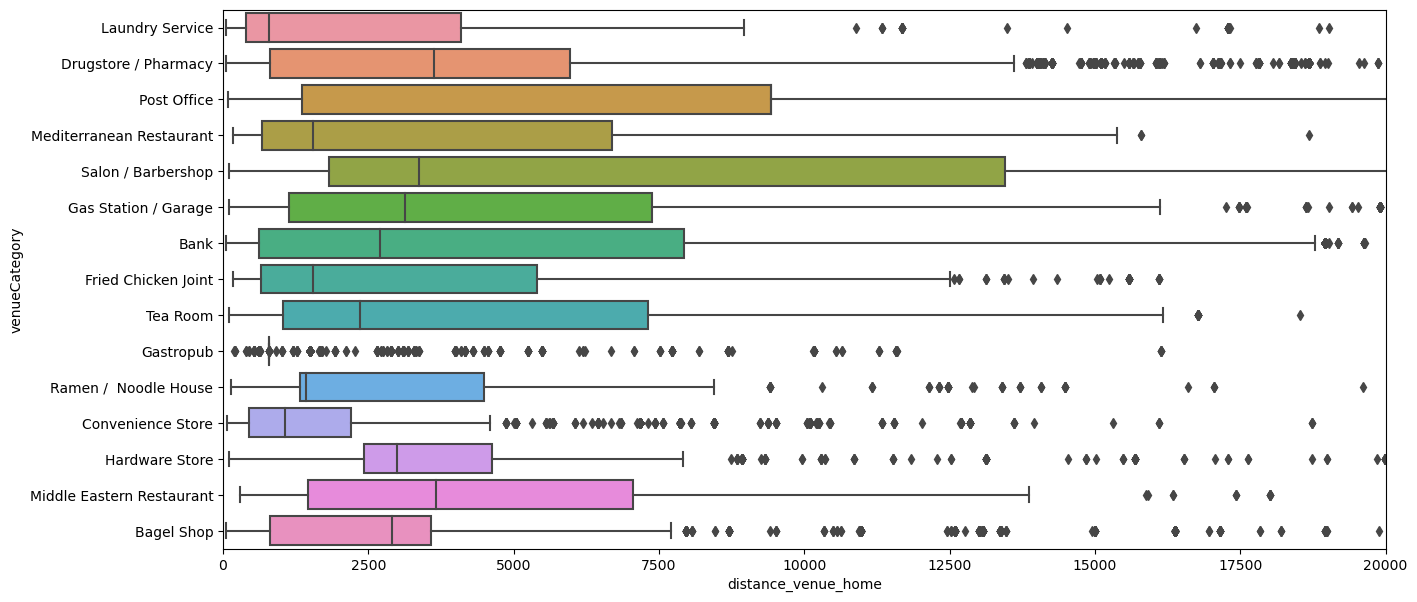

In [46]:
plt.figure(figsize=(15, 7))
plt.xlim(0, 20000)
sns.boxplot(y='venueCategory', x='distance_venue_home'
            ,data=df_clust_home_venue.query('venueCategory in @top_15'), order=top_15);

In [50]:
top = df_clust_home_venue.query('venueCategory in @top_15')
np.percentile(top['distance_venue_home'], [10, 25, 50, 75, 85, 95])

array([  443.15074562,   794.17676904,  2364.89566367,  6830.3534737 ,
        9420.06720882, 15093.87282787])

#### Топ 15 самых удаленных часто посещаемых от дома локаций<a id=step14>

In [47]:
bottom_15 = venue_cat['venueCategory'].tail(15).to_list()

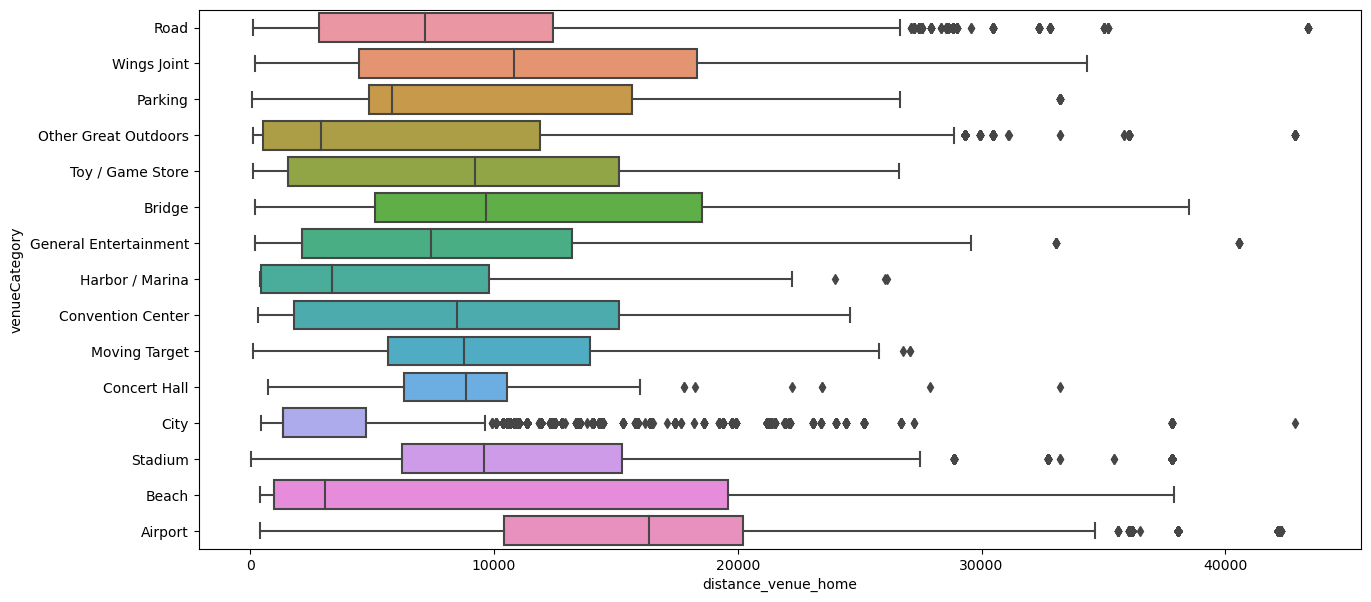

In [48]:
plt.figure(figsize=(15, 7))
sns.boxplot(y='venueCategory', x='distance_venue_home'
            ,data=df_clust_home_venue.query('venueCategory in @bottom_15'), order=bottom_15);

In [52]:
bottom = df_clust_home_venue.query('venueCategory in @bottom_15')
np.percentile(bottom['distance_venue_home'], [10, 25, 50, 75, 85, 95])

array([ 1146.9296654 ,  3561.43911158,  9717.27915862, 17077.45300308,
       20076.30322209, 23742.68323227])

### Выводы<a id=step15>

Мы проанализировали данные 248 типов локаций Нью-Йорка, в которых 564 пользователя отмечались в течение года. 
Прокласторизовали координаты домашних событий и отметок локаций вне дома, чтобы иметь для одной локации 1 координату, без учета погрешности на смещения методом KMean. 
Исключили аномальных пользователей, которые по имеющимся данным отмечались в более, чем 15 локациях в течение дня.
Для 25% пользователей, отмечающихся дома по разным адресам определели один домашний адрес.
По результатам проведенного анализа можно сделать следующие выводы:  
- Наиболее часто пользователи посещали недалеко от дома такие локации, как: 
 аптека, прачечная, почта, парихмахерская, заправка, рестораны средиземноморской, корейской кухонь, продуктовые малого формата, пекарни.  
50% пользователей для этих целей не удалялись от дома более, чем на 2.3 км.
- Наиболее часто пользователи посещали на удалении от дома такие локации, как: магазины игрушек, развлечений, гавань, стадион, аэропорт, концертный зал, совершали прогулки на свежем воздухе, бляж. Что примечательно, в топ 15 отдаленных от дома локаций не входят заведения общественного питания.  
50% пользователей для этих целей удалялись от дома более, чем на 9.7 км.
